In [28]:
import pandas as pd
from langdetect import detect
from langdetect import detect_langs
import googletrans
from googletrans import Translator
from tabulate import tabulate
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud


In [21]:
tracks= pd.read_csv('data/spotify_tracks.csv')
columns = tracks.columns
columns


Index(['Unnamed: 0', 'acousticness', 'album_id', 'analysis_url', 'artists_id',
       'available_markets', 'country', 'danceability', 'disc_number',
       'duration_ms', 'energy', 'href', 'id', 'instrumentalness', 'key',
       'liveness', 'loudness', 'lyrics', 'mode', 'name', 'playlist',
       'popularity', 'preview_url', 'speechiness', 'tempo', 'time_signature',
       'track_href', 'track_name_prev', 'track_number', 'uri', 'valence',
       'type'],
      dtype='object')

In [44]:
columns = tracks.columns
columns

NameError: name 'tracks' is not defined

In [7]:
tracks['lyrics']=tracks['lyrics'].str.replace('\r\n', ' ')
tracks=tracks.dropna()

In [8]:
def detect_language_and_confidence(df, column_name):
    """
    Detect the language and its confidence for each row in the specified column of the DataFrame.

    Parameters:
    - df: DataFrame
    - column_name: the column for which to detect the language

    Returns:
    - DataFrame with new columns named 'language' and 'confidence' containing detected languages and their confidences
    """
    
    def get_lang_confidence(text):
        try:
            detected = detect_langs(text)
            # Assuming the most probable language is the one we want
            lang = detected[0].lang
            conf = detected[0].prob
            return lang, conf
        except:
            return 'unknown', None

    df['language'], df['confidence'] = zip(*df[column_name].map(get_lang_confidence))
    
    return df


In [9]:
lyrics_lang=detect_language_and_confidence(tracks,'lyrics')
c1=lyrics_lang.columns[0]
tracks_lang = lyrics_lang.drop(columns=c1)

In [10]:
tracks_lang.to_csv('data/tracks_spotify_lang.csv', index=False)

In [2]:
tracks_lang=pd.read_csv('data/tracks_spotify_lang.csv')
filtered_df = tracks_lang[~tracks_lang['language'].isin(['en', 'unknown'])]

In [7]:
filtered_df[['id','lyrics','language','confidence']]

,id,lyrics,language,confidence
35,58QDB1sKe1wHZEvngevtGE,"Entiende, que tu misma te haces daño Al pedir...",es,0.999995
40,568qmPhxzAiB6SXxZeRBjg,18 kilates...!! Ya yo me olvide ti Ya yo me o...,es,0.999995
45,6lgHNsNnN2ohPCBPtXwqvI,18 kilates...!! Ya yo me olvide ti Ya yo me o...,es,0.999996
50,6P0a1zjJ0rbw59c3Wah6pn,No me llamas y te la pasas a escondidas Estoy...,es,0.999995
55,6jIHs2L87ZsXMxx2zbZwH5,"Cansado de buscar, y herido en mil fracasos...",es,0.999996
...,...,...,...,...
101905,0dFZjxL6drxK9oupqmF773,Quisiera empezar Volver a cruzar despacio Ima...,es,0.999997
101906,29WK73lMQpLELfHd6PfbjY,Quisiera empezar Volver a cruzar despacio Ima...,es,0.999996
101909,3zZ4thsaNvldGqqZz34cLc,"Gefährliche Kiki, Kiki, ba-da, ba-ba-bau Mi...",de,0.999995
101910,46rtM64AlJF9Kxf1c1Eie6,Eine Vinyl aus der Hülle zieh'n (eins-a) Si...,de,0.999997


In [14]:
filtered_df['char_count'] = filtered_df['lyrics'].str.len()

/var/folders/60/s86dq17j5zd4vn2hf6ywd3200000gn/T/ipykernel_7276/3645812127.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['char_count'] = filtered_df['lyrics'].str.len()


In [14]:
def translate_lyrics(df, column_name, lan_src_column):
    """
    Translate the text for each row in the specified column of the DataFrame.

    Parameters:
    - df: DataFrame
    - column_name: str, the column to translate the text
    - lan_src_column: str, the column containing source language codes

    Returns:
    - DataFrame with a new column named 'text_trans' containing translated texts
    """
    
    translator = Translator()
    translation_count = 0
    
    def get_translation(row, text_column, lan_src_column):
        nonlocal translation_count
        text = row[text_column]
        lan_scr = row[lan_src_column]
        try:
            # Translate the text and return it
            translated_text = translator.translate(text, dest='en', src=lan_scr).text
            translation_count += 1
            return translated_text
        except Exception as e:
            print(f"Translation error: {e}")
            return None

    # Apply the translation function to the DataFrame and store the result in a new column 'text_trans'
    df['text_trans'] = df.apply(lambda row: get_translation(row, column_name, lan_src_column), axis=1)
    
    print(f"Translated {translation_count} rows.")
    
    return df

In [ ]:
#translate_lyrics(filtered_df,'lyrics','language')

In [22]:
translator = Translator()
my_translation = translator.translate(filtered_df['lyrics'][35], src='es', dest='en')
print(my_translation.text)

Understand that you hurt yourself when asking me to move away from your side, I have been faithful to love you but if you don't want me to love you, I will go today I remembered, these dreams built by the two we wanted a child and aParadise very happy with our love but with your jealousy these dreams collapsed and if you want me to mark me I will do it but you will surprise me when I is far away where you can no longer see me do not ignore love do not fool yourself please my life, listen!As you pretended to forget those beautiful moments we played dad and mom as a child when the cardboard castle we did and I time destroyed it as you want me to go and forget that day we made love on the banks of the sea when the moon cellusI illuminate your skin tell me who made you a woman you will miss me when I is very far where you can no longer see me do not ignore love, do not fool yourself please you will surprise me when I is very far where you can no longer see me do not ignore love, do not foo

In [3]:
tracks_lang_no_dup = tracks_lang.drop_duplicates(subset='lyrics', keep='first').reset_index()


In [91]:
len(tracks_lang_no_dup)


40816

In [4]:
countries = tracks_lang_no_dup['language'].value_counts().head(10)
countries

en    25728
es     6070
pt     1942
fr     1438
de      883
fi      753
it      743
sv      677
da      530
nl      448
Name: language, dtype: int64

In [5]:
tracks_lang_no_dup['lyrics'] = tracks_lang_no_dup['lyrics'].str.lower()
tracks_lang_no_dup = tracks_lang_no_dup[tracks_lang_no_dup['language'].isin(['en'])]

In [6]:
tracks_lang_no_dup['lyrics']

0          perhaps i am bound to be restless always yea...
1         your gods and my gods-do you or i know which ...
2          closed off from love, i didn't need the pain...
3         pain, n. an uncomfortable frame of mind that ...
4         if there were an ocean we’d be wading in the ...
                               ...                        
40811      black fingernails, red wine i wanna make you...
40812      i got killed by black bugs on my video game ...
40813     no more maybes your baby's got rabies sitting...
40814     walking down the street with some evil in my ...
40815     there's not enough hours in my day to tell yo...
Name: lyrics, Length: 25728, dtype: object

In [7]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tomtom_ghost/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [8]:
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return " ".join([word for word in words if word.lower() not in stop_words])

tracks_lang_no_dup['lyrics'] = tracks_lang_no_dup['lyrics'].apply(remove_stopwords)

In [10]:
def tokenize_text(text):
    return nltk.word_tokenize(str(text))

In [11]:
tracks_lang_no_dup['lyrics'] = tracks_lang_no_dup['lyrics'].apply(tokenize_text)

In [64]:
filtered_df = tracks_lang_no_dup[tracks_lang_no_dup['id'] == '0RKqylCDwg0Lzq8Stu266U'] ['lyrics']
a=filtered_df.iloc[0]
a

['shine',
 'bright',
 'like',
 'diamond',
 'shine',
 'bright',
 'like',
 'diamond',
 'shining',
 'bright',
 'like',
 'diamond',
 'find',
 'light',
 'beautiful',
 'sea',
 'choose',
 'happy',
 ',',
 "'re",
 'like',
 'diamonds',
 'sky',
 "'re",
 'shooting',
 'star',
 'see',
 'visions',
 'ecstasy',
 'hold',
 ',',
 "'m",
 'alive',
 "'re",
 'like',
 'diamonds',
 'sky',
 'knew',
 "'d",
 'become',
 'one',
 'right',
 'away',
 'oh',
 ',',
 'right',
 'away',
 'first',
 'sight',
 'felt',
 'energy',
 'sun',
 'rays',
 'saw',
 'life',
 'inside',
 'eyes',
 'shine',
 'bright',
 ',',
 'tonight',
 "'re",
 'beautiful',
 'like',
 'diamonds',
 'sky',
 'eye',
 'eye',
 ',',
 'alive',
 "'re",
 'beautiful',
 'like',
 'diamonds',
 'sky',
 'shine',
 'bright',
 'like',
 'diamond',
 'shine',
 'bright',
 'like',
 'diamond',
 'shining',
 'bright',
 'like',
 'diamond',
 "'re",
 'beautiful',
 'like',
 'diamonds',
 'sky',
 'shine',
 'bright',
 'like',
 'diamond',
 'shine',
 'bright',
 'like',
 'diamond',
 'shining',
 'b

In [23]:
tracks_lang_no_dup['WordCount'] = tracks_lang_no_dup['lyrics'].apply(len)
filtered_df = tracks_lang_no_dup[tracks_lang_no_dup['WordCount'] < 5000]

In [25]:
len(filtered_df)

25690

In [22]:
tracks_lang_no_dup[['WordCount','lyrics','name']].sort_values(by='WordCount',ascending=False)

,WordCount,lyrics,name
28831,29577,"[summary, evidence, monell, policy, practice, ...",Hard to Say I'm Sorry / Get Away - Remastered
33931,20379,"[last, updated, :, 10/6/2018, ,, 5:16pm, mst, ...",Zigo (Remix) [feat. Diamond Platnumz]
18967,15697,"[life, milton, already, written, many, forms, ...",Kig Forbi
3455,14425,"[&, nbsp, verse, 1., foolish, galatians, ., ap...",Psalm 60
10,14160,"[1., city, snakes, eddie, runs, stage, ,, jump...",Angly-Saxy English
...,...,...,...
15615,2,"[getting, getting]",We Gettin' Down
2824,2,"[lyrics, transcribed]",Wings
10009,1,[beach],On The Beach - CRW Edit
9009,1,[yo],Mi Ex


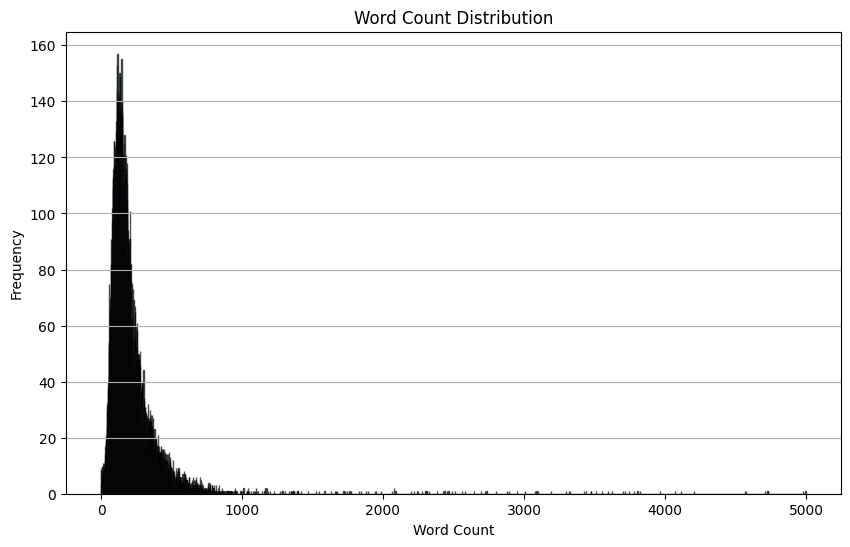

In [24]:
plt.figure(figsize=(10, 6))
plt.hist(filtered_df['WordCount'], bins=range(0, filtered_df['WordCount'].max() + 1), alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Word Count Distribution')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(axis='y')
plt.show()

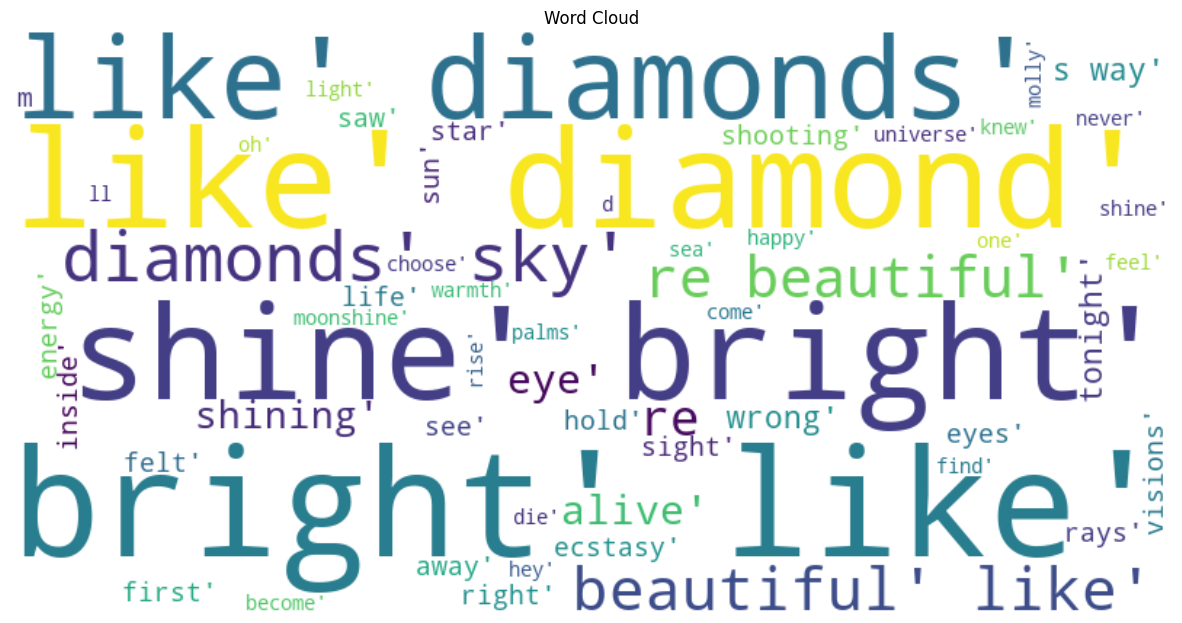

In [69]:
wordcloud = WordCloud(width = 800, height = 400, 
                      random_state=21, max_font_size=110, 
                      background_color='white').generate(str(a))

# Plot the word cloud
plt.figure(figsize=(15, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Word Cloud')
plt.show()

In [70]:
str(a)

'[\'shine\', \'bright\', \'like\', \'diamond\', \'shine\', \'bright\', \'like\', \'diamond\', \'shining\', \'bright\', \'like\', \'diamond\', \'find\', \'light\', \'beautiful\', \'sea\', \'choose\', \'happy\', \',\', "\'re", \'like\', \'diamonds\', \'sky\', "\'re", \'shooting\', \'star\', \'see\', \'visions\', \'ecstasy\', \'hold\', \',\', "\'m", \'alive\', "\'re", \'like\', \'diamonds\', \'sky\', \'knew\', "\'d", \'become\', \'one\', \'right\', \'away\', \'oh\', \',\', \'right\', \'away\', \'first\', \'sight\', \'felt\', \'energy\', \'sun\', \'rays\', \'saw\', \'life\', \'inside\', \'eyes\', \'shine\', \'bright\', \',\', \'tonight\', "\'re", \'beautiful\', \'like\', \'diamonds\', \'sky\', \'eye\', \'eye\', \',\', \'alive\', "\'re", \'beautiful\', \'like\', \'diamonds\', \'sky\', \'shine\', \'bright\', \'like\', \'diamond\', \'shine\', \'bright\', \'like\', \'diamond\', \'shining\', \'bright\', \'like\', \'diamond\', "\'re", \'beautiful\', \'like\', \'diamonds\', \'sky\', \'shine\', \'

In [32]:
str(filtered_df)

'5277    [shine, bright, like, diamond, shine, bright, ...\nName: lyrics, dtype: object'